# Nuvem de partículas (PSO)

```
1. P = população inicial de tamanho m
2. Enquanto critério de parada == false
    a. Para cada partícula p em P
        - Se f(p) > pbest, então pbest = f(p)
    b. gbest = melhor pbest da vizinhaça
    c. Para cada partícula p em P
        - vi = wvi 
                + c1 * r1 (pbest - xi) 
                + c2 * r2 (gbest - xi)
        - pi = pi + vi
3. retorna o gbest
```

In [ ]:
%pip install rich
# %pip install latexify-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import annotations

from random import uniform

from typing import List
from typing import Dict
from typing import Tuple
from typing import Callable

from dataclasses import dataclass
from dataclasses import field

from enum import Enum
from copy import deepcopy
from random import random

import math
# import latexify

import matplotlib as mpl
import matplotlib.pyplot as plt

from rich import print
from rich.console import Console
from rich.table import Table

console = Console()

In [ ]:
class TipoOtimizacao(Enum):
    """Define o tipo de otimização:
        - MIN: minimização
        - MAX: maximização
    """
    MIN = 0
    MAX = 1

In [ ]:
@dataclass
class Particula:
    """Representação de uma partícula.

    Attributes
    ----------
    n : int
        Tamanho da partícula.

    x : list, optional
        Vetor com a solução do problema.
    
    v : list, optional    
        Vetor de deslocamento.
    
    fitness: float
        Valor do fitness da partícula.
    
    pbest: Particula
        Melhor localização da partícula ao longo do tempo.
    
    gbest: Particula
        Melhor partícula na vizinhança.
    
    tipo: TipoOtimizacao
        Tipo de otimização a ser aplicada.

    dominio: list
        Lista com o domínio (min, max) de cada uma das variáveis da solução

    """
    n: int

    x: List[float] = field(default_factory=list)
    v: List[float] = field(default_factory=list)

    fitness: float = 0

    gbest: Particula = None
    pbest: Particula = None

    dominio: List[Tuple[int, int]] = field(default_factory=list)

    tipo_otimizacao: TipoOtimizacao = TipoOtimizacao.MIN

    def __post_init__(self):
        if self.x: return
            
        if self.dominio:
            self.x = [uniform(self.dominio[i][0], self.dominio[i][1]) for i in range(self.n)]
            self.v = [uniform(self.dominio[i][0], self.dominio[i][1])  for i in range(self.n)]
        else:
            self.x = [random() for _ in range(self.n)]
            self.v = [random() for _ in range(self.n)]

        self.pbest = self

        if self.tipo_otimizacao == TipoOtimizacao.MIN:
            self.fitness = math.inf
        else:
            self.fitness = -math.inf

    def eh_melhor(self, outra: Particula):
        """Verifica se a partícula é melhor que a outra.
       
        Attributes
        ----------
        outra : Particula
            Partícula a ser comparada.

        Returns
        -------
        bool
            True caso a partícula seja melhor, False caso contrário.

        """
        if self.tipo_otimizacao == TipoOtimizacao.MIN:
            return self.fitness < outra.fitness
        return self.fitness > outra.fitness


In [ ]:
def pso(w: float, 
        c1: float, 
        c2: float, 
        tam_populacao: int, 
        max_iteracoes: int,
        fitness: Callable[[Particula], float],
        dominio: List[Tuple[int, int]] = None):
    """Executa o algoritmo de otimização por nuvem de partículas.

    Attributes
    ----------
    w : float
        Coeficiente de inércia: valor entre 0,4 e 0,9.

    c1 : float
        Fator de ponderação de comportamento cognitivo.

    c2 : float
        Fator de ponderação de comportamento social.

    tam_populacao : int
        Tamanho da população.

    max_iteracoes : int
        Número máximo de iterações.

    fitness : callable
        Função de avaliação das partículas.

    dominio: list
        Lista com o domínio (min, max) de cada uma das variáveis da solução

    """
    # Configuração de impressão
    table = Table(show_header=True, header_style="bold magenta")
    table.add_column("i", width=5)
    table.add_column("Solução")
    table.add_column("Fitness", justify="right")
    
    # 1. P = população inicial de tamanho m
    P = [Particula(n=2, dominio=dominio) for _ in range(tam_populacao)]

    # Inicializa a melhor solução global - será atualizado na primeira iteração
    gbest = deepcopy(P[0])

    # 2. Enquanto critério de parada == false
    for k in range(max_iteracoes):

        # a. Atualiza o pbest de cada partícula
        for p in P:

            # - Atualiza o fitness da partícula
            p.fitness = fitness(p)

            # - Atualiza o pbest da partícula
            if p.eh_melhor(p.pbest):
                p.pbest = deepcopy(p)


        # b. Atualiza o gbest - considerando visão global
        for p in P:
            if p.eh_melhor(gbest):
                gbest = p
            
        # Copia o objeto inteiro 
        # A solução será alterada no processo de deslocamento
        gbest = deepcopy(gbest)

        # Nesta implementação, a vizinhança é a população inteira
        for p in P:
            p.gbest = gbest

        # c. Atualiza a posição da partícula
        for p in P:
            for i in range(p.n):
                p.v[i] = W * p.v[i] \
                            + C1 * random() * (p.pbest.x[i] - p.x[i]) \
                            + C2 * random() * (p.gbest.x[i] - p.x[i])
                p.x[i] += p.v[i]

        # Visualiza todas as partículas
        plt.plot([p.x[0] for p in P], [p.x[1] for p in P], 'o', color='b', scalex=False, scaley=False)
        plt.plot([gbest.x[0]], [gbest.x[1]], 'o', color='r',  scalex=False, scaley=False)
        plt.xlim(dominio[0])
        plt.ylim(dominio[1])
        plt.show()

        # Imprime a melhor partícula
        table.add_row(str(k), f'{[f"{i:.4f}" for i in gbest.x]}', f'{gbest.fitness:.3f}')
    
    console.print(table)

    return gbest

## Problema 1

Encontrar os zeros de uma função quadrática.

In [ ]:
def funcao_fitness(p: Particula):
    x1 = p.x[0]
    x2 = p.x[1]

    return abs(2 * x1 ** 2 - 6 * x1 - 9) + \
           abs(2 * x2 ** 2 - 6 * x2 - 9) 

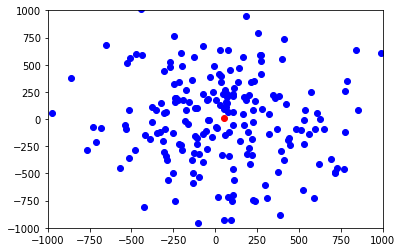

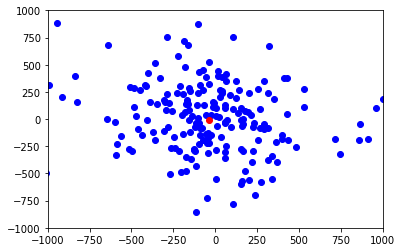

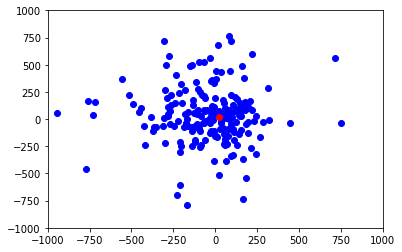

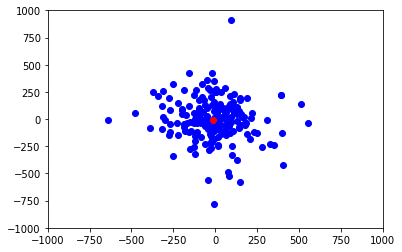

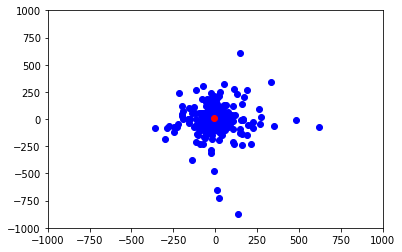

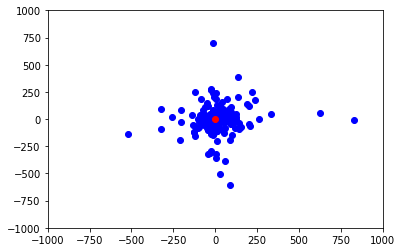

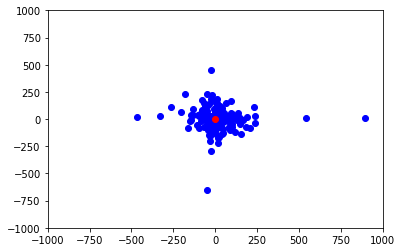

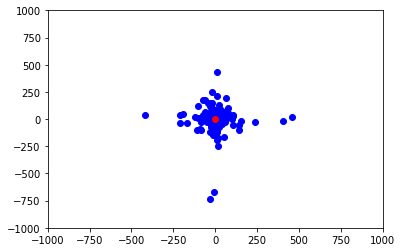

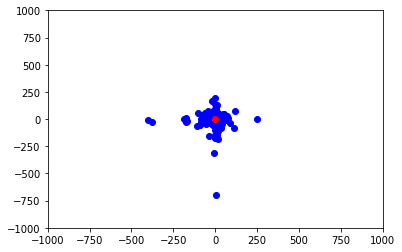

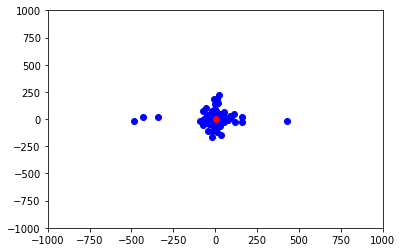

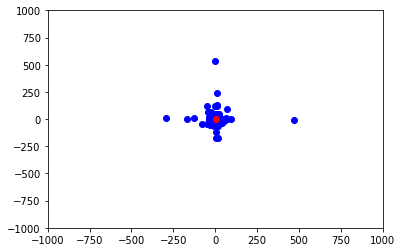

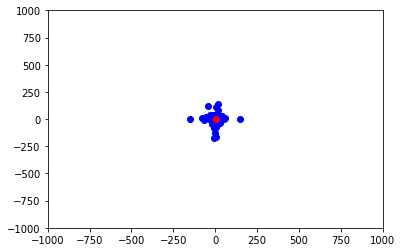

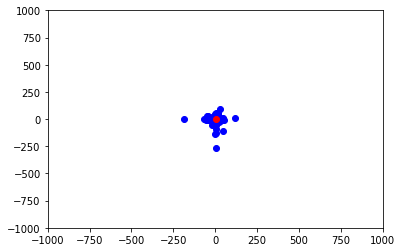

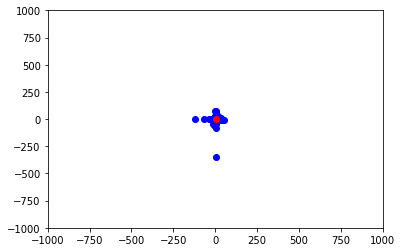

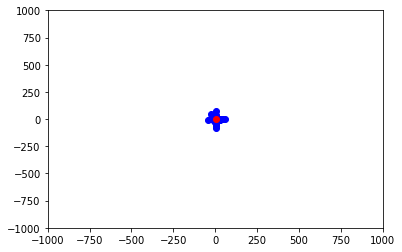

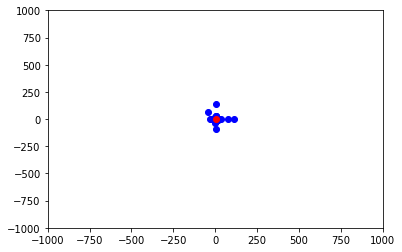

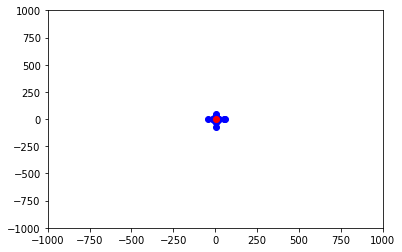

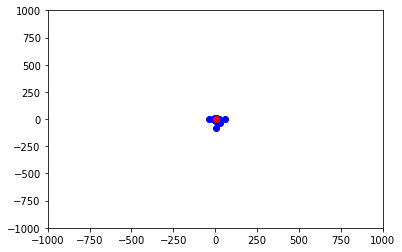

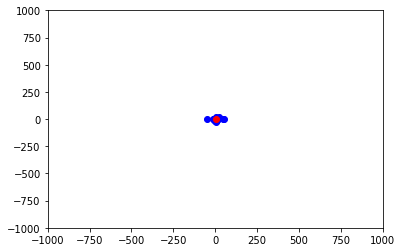

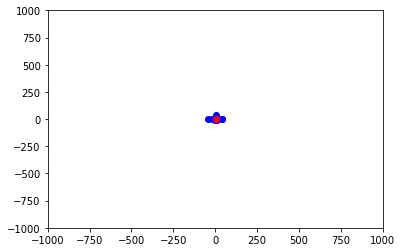

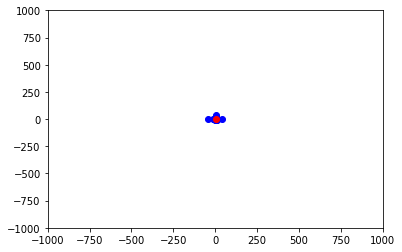

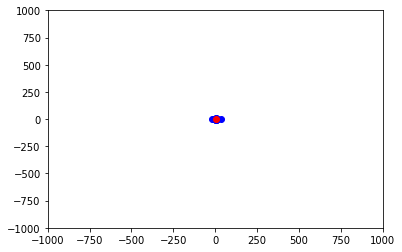

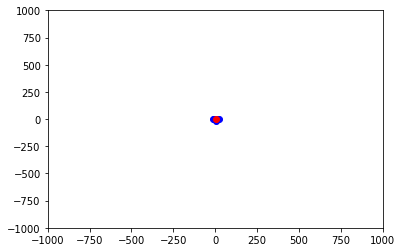

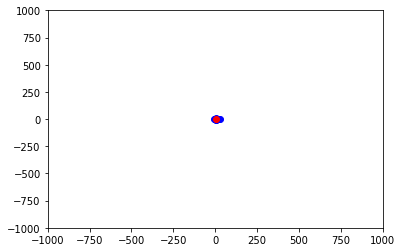

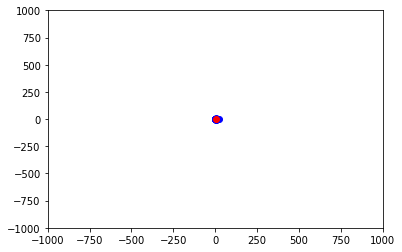

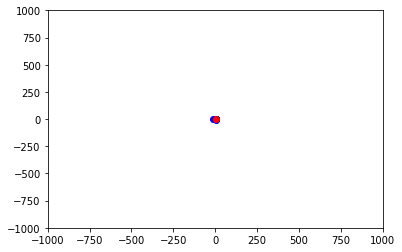

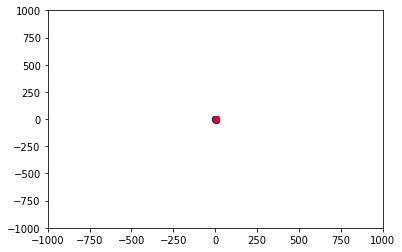

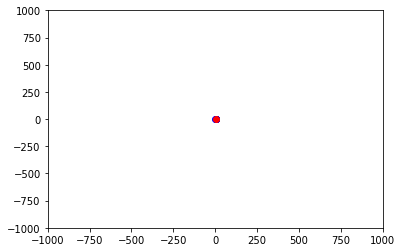

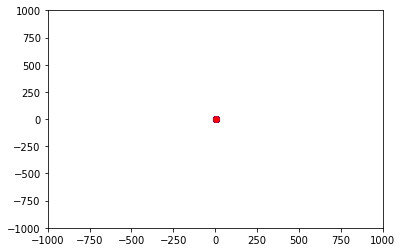

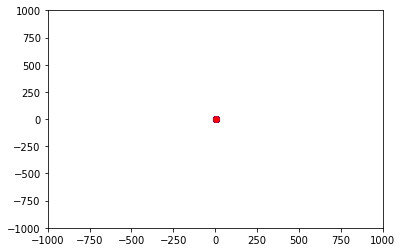

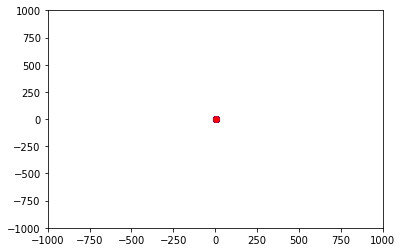

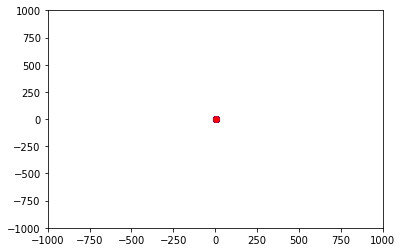

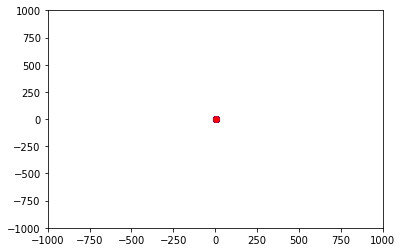

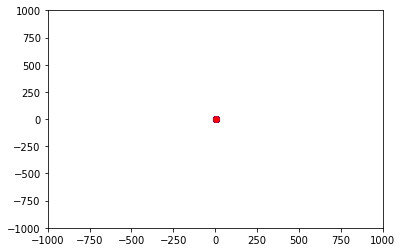

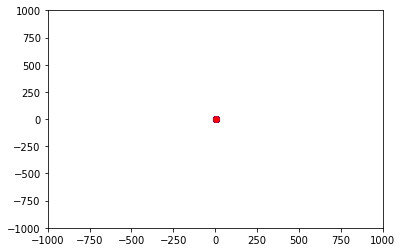

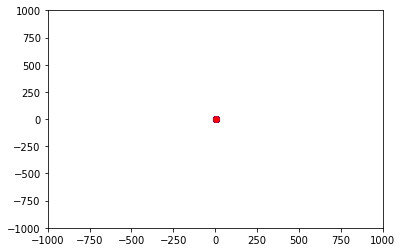

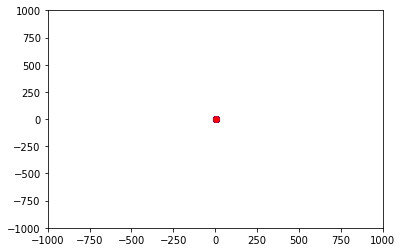

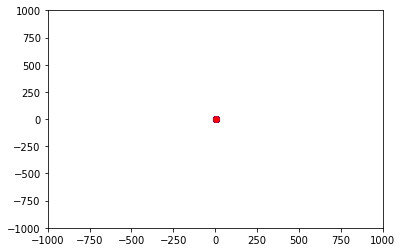

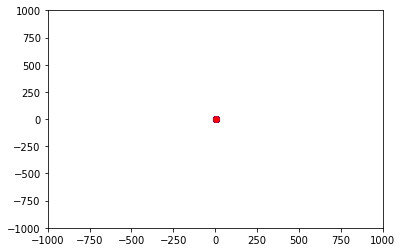

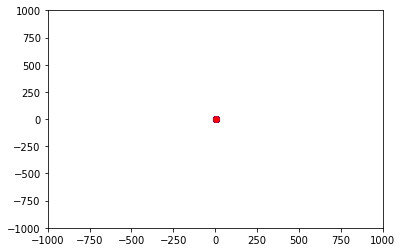

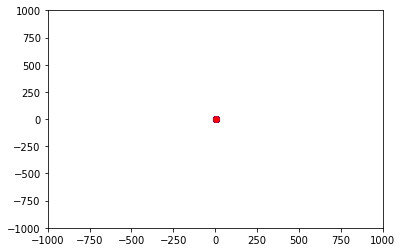

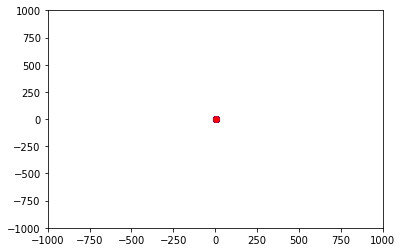

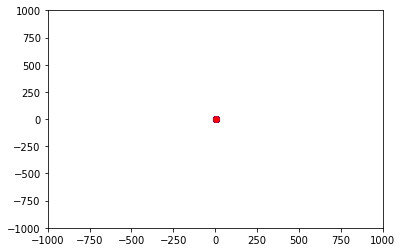

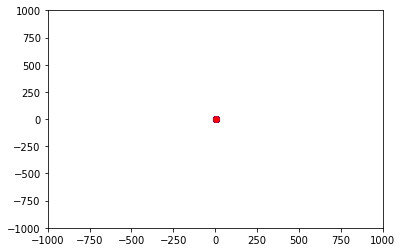

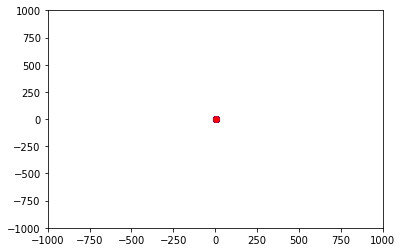

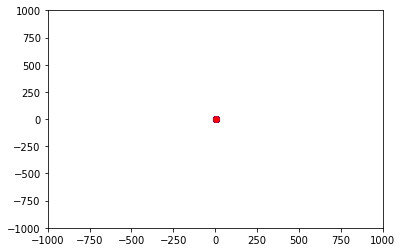

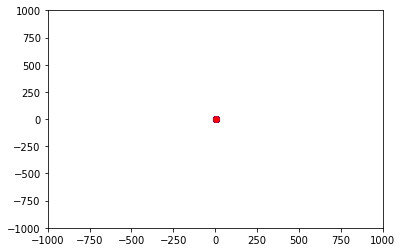

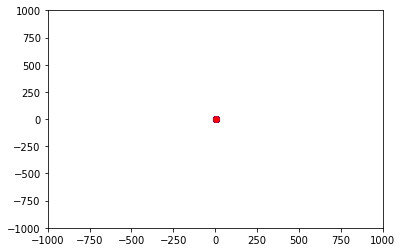

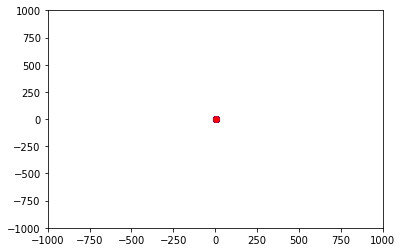

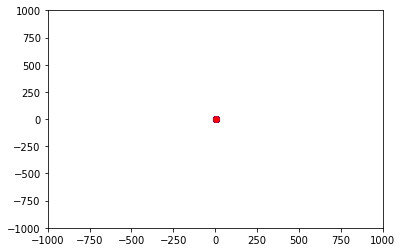

┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ i     ┃ Solução                 ┃  Fitness ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ 0     │ ['50.6321', '13.3776']  │ 5083.089 │
│ 1     │ ['-39.4265', '-7.0856'] │ 3470.380 │
│ 2     │ ['20.4141', '16.6539']  │ 1147.766 │
│ 3     │ ['-9.9268', '-11.7526'] │  585.405 │
│ 4     │ ['-8.9233', '7.0578']   │  252.067 │
│ 5     │ ['1.3365', '-1.7180']   │   20.658 │
│ 6     │ ['1.3365', '-1.7180']   │   20.658 │
│ 7     │ ['1.3365', '-1.7180']   │   20.658 │
│ 8     │ ['-1.5440', '-0.0621']  │   13.652 │
│ 9     │ ['3.8799', '-0.8707']   │    4.432 │
│ 10    │ ['3.8799', '-0.8707']   │    4.432 │
│ 11    │ ['3.8799', '-0.8707']   │    4.432 │
│ 12    │ ['3.8799', '-0.8707']   │    4.432 │
│ 13    │ ['3.8799', '-0.8707']   │    4.432 │
│ 14    │ ['3.9271', '-1.1351']   │    2.106 │
│ 15    │ ['4.0465', '-1.1181']   │    0.740 │
│ 16    │ ['4.0942', '-1.1113']   │    0.178 │
│ 17    │ ['4.0942', '-1.1113']   │    0.178 │
│ 18    │ ['4.0942', '-1.1113']   │    0.178 │
│ 19    │ ['4.0952', '-1.1113']   │    0.167 │
│ 20    │ ['4.0952', '-1.1113']   │    0.167 │
│ 21    │ ['4.0952', '-1.1113']   │    0.167 │
│ 22    │ ['4.0965', '-1.1109']   │    0.150 │
│ 23    │ ['4.0954', '-1.0930']   │    0.080 │
│ 24    │ ['4.0954', '-1.0930']   │    0.080 │
│ 25    │ ['4.0963', '-1.0950']   │    0.050 │
│ 26    │ ['4.0963', '-1.0950']   │    0.050 │
│ 27    │ ['4.0973', '-1.0979']   │    0.011 │
│ 28    │ ['4.0973', '-1.0979']   │    0.011 │
│ 29    │ ['4.0972', '-1.0982']   │    0.010 │
│ 30    │ ['4.0972', '-1.0982']   │    0.010 │
│ 31    │ ['4.0985', '-1.0982']   │    0.005 │
│ 32    │ ['4.0979', '-1.0981']   │    0.002 │
│ 33    │ ['4.0979', '-1.0981']   │    0.002 │
│ 34    │ ['4.0981', '-1.0980']   │    0.002 │
│ 35    │ ['4.0981', '-1.0980']   │    0.002 │
│ 36    │ ['4.0981', '-1.0980']   │    0.001 │
│ 37    │ ['4.0981', '-1.0980']   │    0.000 │
│ 38    │ ['4.0981', '-1.0981']   │    0.000 │
│ 39    │ ['4.0981', '-1.0981']   │    0.000 │
│ 40    │ ['4.0981', '-1.0981']   │    0.000 │
│ 41    │ ['4.0981', '-1.0981']   │    0.000 │
│ 42    │ ['4.0981', '-1.0981']   │    0.000 │
│ 43    │ ['4.0981', '-1.0981']   │    0.000 │
│ 44    │ ['4.0981', '-1.0981']   │    0.000 │
│ 45    │ ['4.0981', '-1.0981']   │    0.000 │
│ 46    │ ['4.0981', '-1.0981']   │    0.000 │
│ 47    │ ['4.0981', '-1.0981']   │    0.000 │
│ 48    │ ['4.0981', '-1.0981']   │    0.000 │
│ 49    │ ['4.0981', '-1.0981']   │    0.000 │
└───────┴─────────────────────────┴──────────┘

In [ ]:
# Constantes
W = 0.4

C1 = 2
C2 = 2

M = 200

MAX_ITER = 50

DOMINIO = [
    (-1000, 1000),    # x1
    (-1000, 1000),    # x2
]

solucao = pso(W, C1, C2, M, MAX_ITER, funcao_fitness, DOMINIO)